Connect Weights and Biases GUI

In [1]:
#Install packages
%pip install wandb -qU
%pip install --no-deps scikeras
%pip install tensorflow-addons

     |████████████████████████████████| 1.9 MB 4.7 MB/s 
     |████████████████████████████████| 182 kB 15.5 MB/s 
     |████████████████████████████████| 173 kB 38.3 MB/s 
     |████████████████████████████████| 62 kB 849 kB/s 
     |████████████████████████████████| 168 kB 38.0 MB/s 
     |████████████████████████████████| 168 kB 41.1 MB/s 
     |████████████████████████████████| 166 kB 46.9 MB/s 
     |████████████████████████████████| 166 kB 44.7 MB/s 
     |████████████████████████████████| 162 kB 43.1 MB/s 
     |████████████████████████████████| 162 kB 38.6 MB/s 
     |████████████████████████████████| 158 kB 25.1 MB/s 
     |████████████████████████████████| 157 kB 36.7 MB/s 
     |████████████████████████████████| 157 kB 32.5 MB/s 
     |████████████████████████████████| 157 kB 40.3 MB/s 
     |████████████████████████████████| 157 kB 41.2 MB/s 
     |████████████████████████████████| 157 kB 37.4 MB/s 
     |████████████████████████████████| 157 kB 24.5 MB/s 
     |███████████

In [3]:
#imports
import wandb
from wandb.keras import WandbCallback
import numpy as np
import pandas as pd
from re import X
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
import sklearn
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from keras.models import Sequential
from keras.layers import Dense
from keras import backend as K
import tensorflow as tf
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns
from sklearn.metrics import roc_auc_score
import tensorflow_addons as tfa
from tensorflow.keras.layers import Dropout

In [4]:
#connect drive containing dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Obtain Dataset

In [5]:
#Use pandas read_csv() function to import data
df = pd.read_csv('/content/drive/MyDrive/CSC461/Final Data /Statewide.csv')
df.head()

,CITY,ZIP CODE,CURRENT PARTY,YEAR OF BIRTH,ELECTION 3,ELECTION 4,ELECTION 5,ELECTION 6,ELECTION 7,ELECTION 8,PARTY 5,PARTY 6,PARTY 8,TGT STATEWIDE PRIMARY,TGT PARTY AFFILIATION
0,6,2921,1,1962,1,1,1,0,1,1,3,0,2,0,0
1,6,2920,2,1984,0,1,0,0,0,0,0,0,0,0,0
2,32,2878,3,1968,1,1,0,1,1,1,0,3,3,1,3
3,32,2878,3,1962,1,1,0,1,1,0,0,3,0,1,3
4,34,2889,3,1996,0,1,0,0,0,0,0,0,0,0,0


Define features and label

In [6]:
#Set datatype to int8 to conserve memory 
df = df.astype("int8")

In [7]:
df = df.drop(["CITY",'ZIP CODE'], axis=1)
print(df.shape)

#Dropping rows that involve 0 (non-voters)
df = df.loc[df["TGT PARTY AFFILIATION"] != 0]
#Dropping the one row where someone voted as unafiliated (1) along with moderate party voters (4) because these act as outliers. 
#Since we are trying to predict where swing voters will vote for, only two output units are needed (democrat and republican)
df = df.loc[df["TGT PARTY AFFILIATION"] != 1]
df = df.loc[df["TGT PARTY AFFILIATION"] != 4]
print(df.shape)
print(df.head)


(816297, 13)
(136911, 13)
<bound method NDFrame.head of         CURRENT PARTY  YEAR OF BIRTH  ELECTION 3  ELECTION 4  ELECTION 5  \
2                   3            -80           1           1           0   
3                   3            -86           1           1           0   
11                  2            -87           0           1           0   
12                  2            -67           0           1           1   
13                  2            -67           0           1           1   
...               ...            ...         ...         ...         ...   
816269              3            -85           0           1           0   
816270              3            -83           0           1           0   
816278              2            -55           1           1           0   
816286              2            -95           1           1           1   
816287              2            -89           1           1           1   

        ELECTION 6  ELECTION 7 

In [8]:
#Setting our prediction target and dropping target columns from the main dataset
predict = 'TGT PARTY AFFILIATION'
drops = ['TGT STATEWIDE PRIMARY','TGT PARTY AFFILIATION']
X = df.drop(drops, axis=1)
y = df[predict]
print(X.head())
print(y.head())


    CURRENT PARTY  YEAR OF BIRTH  ELECTION 3  ELECTION 4  ELECTION 5  \
2               3            -80           1           1           0   
3               3            -86           1           1           0   
11              2            -87           0           1           0   
12              2            -67           0           1           1   
13              2            -67           0           1           1   

    ELECTION 6  ELECTION 7  ELECTION 8  PARTY 5  PARTY 6  PARTY 8  
2            1           1           1        0        3        3  
3            1           1           0        0        3        0  
11           0           1           1        0        0        3  
12           1           1           1        2        2        2  
13           1           1           1        2        2        2  
2     3
3     3
11    2
12    2
13    2
Name: TGT PARTY AFFILIATION, dtype: int8


In [9]:
#transforming data values to 1,0 so that we can perform binary cross entropy
# 0 = Democrat
y = y.replace(2,0)
# 1 = Republican
y = y.replace(3,1)

In [10]:
#sanity check
df[predict].unique()

array([3, 2], dtype=int8)

In [11]:
y

2         1
3         1
11        0
12        0
13        0
         ..
816269    1
816270    1
816278    0
816286    0
816287    0
Name: TGT PARTY AFFILIATION, Length: 136911, dtype: int8

In [12]:
#Show the data-split (unbalanced dataset)
print(y.shape)
np.count_nonzero(y)

(136911,)


21439

In [13]:
#creates labels for classes
le = LabelEncoder()
le.fit_transform(y)

array([1, 1, 0, ..., 0, 0, 0])

In [14]:
#train_test_split the dataset
X_train, X_test, y_train, y_test =  sklearn.model_selection.train_test_split(X, y, test_size=0.3, shuffle=True)

print(f'Train y: {y_train.shape}')
print(f'Train X: {X_train.shape}')
print(f'Test y: {y_test.shape}')
print(f'Test X: {X_test.shape}')

Train y: (95837,)
Train X: (95837, 11)
Test y: (41074,)
Test X: (41074, 11)


In [15]:
#Perform undersampling in an attempt to fix the unbalanced dataset
##################################################################################
undersample = RandomUnderSampler(sampling_strategy='majority')

X_train_under, y_train_under = undersample.fit_resample(X_train, y_train)

print(f'Train y: {y_train_under.shape}')
print(f'Train X: {X_train_under.shape}')
###################################################################################
undersample = RandomUnderSampler(sampling_strategy='majority')

X_test_under, y_test_under = undersample.fit_resample(X_test, y_test)

print(f'Test y: {y_test_under.shape}')
print(f'Test X: {X_test_under.shape}')

Train y: (29872,)
Train X: (29872, 11)
Test y: (13006,)
Test X: (13006, 11)


In [16]:
#set Hyper-parameters for W&B 
run = wandb.init(entity="gotv-ml", project="ann-party-state")
config = run.config
config.opti = 'adamax'
config.batch_size = 64
config.epochs = 200
config.learn_rate = 0.003571
config.fc_layer_size = 13
config.sc_layer_size = 15
config.dropout = 0

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Define Keras Model

In [17]:
def Neural_Net(fc_layer_size=13,sc_layer_size=15,dropout=0):

  # initiate Network
  network = Sequential()

  # input layer that is fully connected with ReLU activation 
  network.add(Dense(11, input_dim=11, activation="relu",use_bias=True,bias_initializer="random_normal", kernel_initializer="he_normal"))
  network.add(Dropout(dropout))
  #hidden layers 
  network.add(Dense(fc_layer_size, activation="relu", use_bias=True, bias_initializer="random_normal", kernel_initializer="he_normal"))
  network.add(Dropout(dropout))
  network.add(Dense(sc_layer_size, activation="relu", use_bias=True, bias_initializer="random_normal", kernel_initializer="he_normal"))

  #Output layer that is fully connected with sigmoid activation
  network.add(Dense(1, activation="sigmoid"))


  # Compile network model.
  network.compile(optimizer=config.opti,
               loss="binary_crossentropy",
               metrics=["accuracy",
               tfa.metrics.F1Score(num_classes=2,
                                  average='micro',
                                  threshold=0.5),
               tf.keras.metrics.AUC(from_logits=True)
                        ]) 
  

  #return completed network
  return network 


Compile The Keras Model

In [18]:

# Wrap Keras model so it can be used by scikit-learn
neural_network = KerasClassifier(
                                build_fn=Neural_Net, 
                                epochs=config.epochs, 
                                batch_size=config.batch_size, 
                                verbose=1,
                                callbacks=[WandbCallback()]
                              )


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Evaluate the Model

In [19]:
#Setup stratified Kfold for cross validation
seed = 7
np.random.seed(seed)
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)

In [ ]:
#ROC performance metric cross_val
scores_roc = cross_val_score(neural_network, X_train, y_train,
                         scoring="roc_auc", cv=kfold)

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/200
999/999 [==============================] - 8s 5ms/step - loss: 0.6780 - accuracy: 0.8197 - f1_score: 0.1407 - auc: 0.6548
Epoch 2/200
999/999 [==============================] - 5s 5ms/step - loss: 0.3857 - accuracy: 0.8660 - f1_score: 0.2832 - auc: 0.7723
Epoch 3/200
999/999 [==============================] - 4s 4ms/step - loss: 0.3151 - accuracy: 0.9040 - f1_score: 0.5749 - auc: 0.8577
Epoch 4/200
999/999 [==============================] - 2s 2ms/step - loss: 0.2412 - accuracy: 0.9497 - f1_score: 0.8127 - auc: 0.8963
Epoch 5/200
999/999 [==============================] - 2s 2ms/step - loss: 0.1749 - accuracy: 0.9686 - f1_score: 0.8903 - auc: 0.9372
Epoch 6/200
999/999 [==============================] - 2s 2ms/step - loss: 0.1325 - accuracy: 0.9704 - f1_score: 0.8971 - auc: 0.9761
Epoch 7/200
999/999 [==============================] - 2s 2ms/step - loss: 0.1113 - accuracy: 0.9707 - f1_score: 0.8990 - auc: 0.9859
Epoch 8/200
999/999 [==============================] - 2s 2ms/

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


999/999 [==============================] - 3s 2ms/step - loss: 0.4638 - accuracy: 0.8429 - f1_score: 0.0000e+00 - auc_1: 0.4421
Epoch 2/200
999/999 [==============================] - 2s 2ms/step - loss: 0.4421 - accuracy: 0.8429 - f1_score: 0.0000e+00 - auc_1: 0.5314
Epoch 3/200
999/999 [==============================] - 2s 2ms/step - loss: 0.4213 - accuracy: 0.8429 - f1_score: 0.0000e+00 - auc_1: 0.6377
Epoch 4/200
999/999 [==============================] - 2s 2ms/step - loss: 0.3882 - accuracy: 0.8429 - f1_score: 0.0000e+00 - auc_1: 0.7420
Epoch 5/200
999/999 [==============================] - 2s 2ms/step - loss: 0.3406 - accuracy: 0.8593 - f1_score: 0.1899 - auc_1: 0.8236
Epoch 6/200
999/999 [==============================] - 2s 2ms/step - loss: 0.2879 - accuracy: 0.9153 - f1_score: 0.6332 - auc_1: 0.8557
Epoch 7/200
999/999 [==============================] - 2s 2ms/step - loss: 0.2477 - accuracy: 0.9579 - f1_score: 0.8467 - auc_1: 0.8530
Epoch 8/200
999/999 [=======================

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


  1/999 [..............................] - ETA: 13:38 - loss: 25.7076 - accuracy: 0.1250 - f1_score: 0.2222 - auc_2: 0.5000

999/999 [==============================] - 3s 2ms/step - loss: 1.3102 - accuracy: 0.7852 - f1_score: 0.1149 - auc_2: 0.4002
Epoch 2/200
999/999 [==============================] - 2s 2ms/step - loss: 0.4506 - accuracy: 0.8430 - f1_score: 0.0000e+00 - auc_2: 0.4526
Epoch 3/200
999/999 [==============================] - 2s 2ms/step - loss: 0.4235 - accuracy: 0.8430 - f1_score: 0.0000e+00 - auc_2: 0.6240
Epoch 4/200
999/999 [==============================] - 2s 2ms/step - loss: 0.3835 - accuracy: 0.8434 - f1_score: 0.0060 - auc_2: 0.7659
Epoch 5/200
999/999 [==============================] - 2s 2ms/step - loss: 0.3286 - accuracy: 0.8682 - f1_score: 0.2795 - auc_2: 0.8485
Epoch 6/200
999/999 [==============================] - 2s 2ms/step - loss: 0.2622 - accuracy: 0.9282 - f1_score: 0.7082 - auc_2: 0.8787
Epoch 7/200
999/999 [==============================] - 2s 2ms/step - loss: 0.2081 - accuracy: 0.9583 - f1_score: 0.8495 - auc_2: 0.8930
Epoch 8/200
999/999 [==============================]

In [ ]:
scores_roc

array([0.99334971, 0.99055463, 0.99277243])

**ROC-AUC** = Area Under the Receiver Operating Characteristic Curve. ROC = curve of probability. Commonly used for performance measurement of classification models. AUC=1 means it has a good measure of separability (1s classified as 1s). AUC=0.7 means there is a 70% chance that the model will be able to distinguish between positive and negative class.

-----------------
**Micro vs macro** = Micro calculates metrics globally by considering each element of the label indicator matrix as a label. Macro calculates metrics for each label, and finds their unweighted mean.

-------------------
**ovr** = One-vs-rest. Computes the AUC of each class against the rest. Treats the multiclass case in the same way as the multilabel case. Sensitive to class imbalance.

-------------------
**ovo** = One-vs-one. Computes the average AUC of all possible pairwise combinations of classes. Insensitive to class imbalance when average = Macro.

In [ ]:
#F1 performance metric cross_val (F1=measure of a test's accuracy)
scores_f1 = cross_val_score(neural_network, X_train, y_train,
                         scoring="f1", cv=kfold)

Epoch 1/200


/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


999/999 [==============================] - 3s 2ms/step - loss: 0.5499 - accuracy: 0.8084 - f1_score: 0.0906 - auc_3: 0.5676
Epoch 2/200
999/999 [==============================] - 2s 2ms/step - loss: 0.4186 - accuracy: 0.8456 - f1_score: 0.0535 - auc_3: 0.6251
Epoch 3/200
999/999 [==============================] - 2s 2ms/step - loss: 0.3720 - accuracy: 0.8664 - f1_score: 0.2888 - auc_3: 0.7306
Epoch 4/200
999/999 [==============================] - 2s 2ms/step - loss: 0.2611 - accuracy: 0.9217 - f1_score: 0.6850 - auc_3: 0.8691
Epoch 5/200
999/999 [==============================] - 2s 2ms/step - loss: 0.1762 - accuracy: 0.9630 - f1_score: 0.8689 - auc_3: 0.9125
Epoch 6/200
999/999 [==============================] - 2s 2ms/step - loss: 0.1350 - accuracy: 0.9701 - f1_score: 0.8958 - auc_3: 0.9515
Epoch 7/200
999/999 [==============================] - 2s 2ms/step - loss: 0.1163 - accuracy: 0.9706 - f1_score: 0.8978 - auc_3: 0.9731
Epoch 8/200
999/999 [==============================] - 2s 2m

500/500 [==============================] - 1s 1ms/step
Epoch 1/200


/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


999/999 [==============================] - 3s 2ms/step - loss: 0.4609 - accuracy: 0.8432 - f1_score: 0.1157 - auc_4: 0.6195
Epoch 2/200
999/999 [==============================] - 2s 2ms/step - loss: 0.3626 - accuracy: 0.8594 - f1_score: 0.1938 - auc_4: 0.7867
Epoch 3/200
999/999 [==============================] - 2s 2ms/step - loss: 0.3190 - accuracy: 0.8885 - f1_score: 0.4552 - auc_4: 0.8323
Epoch 4/200
999/999 [==============================] - 2s 2ms/step - loss: 0.2834 - accuracy: 0.9367 - f1_score: 0.7511 - auc_4: 0.8408
Epoch 5/200
999/999 [==============================] - 2s 2ms/step - loss: 0.2568 - accuracy: 0.9583 - f1_score: 0.8488 - auc_4: 0.8430
Epoch 6/200
999/999 [==============================] - 2s 2ms/step - loss: 0.2412 - accuracy: 0.9641 - f1_score: 0.8720 - auc_4: 0.8454
Epoch 7/200
999/999 [==============================] - 2s 2ms/step - loss: 0.2318 - accuracy: 0.9656 - f1_score: 0.8783 - auc_4: 0.8479
Epoch 8/200
999/999 [==============================] - 2s 2m

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


999/999 [==============================] - 3s 2ms/step - loss: 0.4588 - accuracy: 0.8430 - f1_score: 1.9932e-04 - auc_5: 0.5391
Epoch 2/200
999/999 [==============================] - 2s 2ms/step - loss: 0.4177 - accuracy: 0.8430 - f1_score: 0.0000e+00 - auc_5: 0.6475
Epoch 3/200
999/999 [==============================] - 2s 2ms/step - loss: 0.3830 - accuracy: 0.8440 - f1_score: 0.0137 - auc_5: 0.7590
Epoch 4/200
999/999 [==============================] - 2s 2ms/step - loss: 0.3340 - accuracy: 0.8641 - f1_score: 0.2393 - auc_5: 0.8346
Epoch 5/200
999/999 [==============================] - 2s 2ms/step - loss: 0.2879 - accuracy: 0.9105 - f1_score: 0.6048 - auc_5: 0.8589
Epoch 6/200
999/999 [==============================] - 2s 2ms/step - loss: 0.2543 - accuracy: 0.9450 - f1_score: 0.7900 - auc_5: 0.8623
Epoch 7/200
999/999 [==============================] - 2s 2ms/step - loss: 0.2320 - accuracy: 0.9600 - f1_score: 0.8558 - auc_5: 0.8637
Epoch 8/200
999/999 [==============================]

In [ ]:
scores_f1

array([0.91313559, 0.91197   , 0.90450758])

--------
Conduct k-Fold Cross-Validation Using scikit-learn

In [ ]:
#shows how good the model is 
predictions = cross_val_predict(neural_network, X_train, y_train, cv=kfold)

Epoch 1/200


/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


999/999 [==============================] - 3s 2ms/step - loss: 0.5428 - accuracy: 0.8309 - f1_score: 0.0357 - auc_6: 0.5400
Epoch 2/200
999/999 [==============================] - 2s 2ms/step - loss: 0.4336 - accuracy: 0.8430 - f1_score: 3.9857e-04 - auc_6: 0.5867
Epoch 3/200
999/999 [==============================] - 2s 2ms/step - loss: 0.4126 - accuracy: 0.8430 - f1_score: 1.9940e-04 - auc_6: 0.6569
Epoch 4/200
999/999 [==============================] - 2s 2ms/step - loss: 0.3838 - accuracy: 0.8442 - f1_score: 0.0150 - auc_6: 0.7446
Epoch 5/200
999/999 [==============================] - 2s 2ms/step - loss: 0.3498 - accuracy: 0.8563 - f1_score: 0.1568 - auc_6: 0.8112
Epoch 6/200
999/999 [==============================] - 2s 2ms/step - loss: 0.3139 - accuracy: 0.8908 - f1_score: 0.4687 - auc_6: 0.8429
Epoch 7/200
999/999 [==============================] - 2s 2ms/step - loss: 0.2835 - accuracy: 0.9283 - f1_score: 0.7059 - auc_6: 0.8508
Epoch 8/200
999/999 [==============================]

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


999/999 [==============================] - 3s 2ms/step - loss: 0.6677 - accuracy: 0.8429 - f1_score: 0.0000e+00 - auc_7: 0.5125
Epoch 2/200
999/999 [==============================] - 2s 2ms/step - loss: 0.4317 - accuracy: 0.8429 - f1_score: 0.0000e+00 - auc_7: 0.5965
Epoch 3/200
999/999 [==============================] - 2s 2ms/step - loss: 0.4055 - accuracy: 0.8430 - f1_score: 0.0000e+00 - auc_7: 0.6869
Epoch 4/200
999/999 [==============================] - 2s 2ms/step - loss: 0.3607 - accuracy: 0.8544 - f1_score: 0.1379 - auc_7: 0.7875
Epoch 5/200
999/999 [==============================] - 2s 2ms/step - loss: 0.3030 - accuracy: 0.9075 - f1_score: 0.5936 - auc_7: 0.8452
Epoch 6/200
999/999 [==============================] - 2s 2ms/step - loss: 0.2614 - accuracy: 0.9485 - f1_score: 0.8064 - auc_7: 0.8573
Epoch 7/200
999/999 [==============================] - 2s 2ms/step - loss: 0.2328 - accuracy: 0.9641 - f1_score: 0.8724 - auc_7: 0.8587
Epoch 8/200
999/999 [===========================

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


  1/999 [..............................] - ETA: 14:02 - loss: 0.4189 - accuracy: 0.9062 - f1_score: 0.0000e+00 - auc_8: 0.5014

999/999 [==============================] - 3s 2ms/step - loss: 0.4427 - accuracy: 0.8430 - f1_score: 0.0000e+00 - auc_8: 0.5213
Epoch 2/200
999/999 [==============================] - 2s 2ms/step - loss: 0.4180 - accuracy: 0.8430 - f1_score: 0.0000e+00 - auc_8: 0.6440
Epoch 3/200
999/999 [==============================] - 2s 2ms/step - loss: 0.3871 - accuracy: 0.8453 - f1_score: 0.0295 - auc_8: 0.7364
Epoch 4/200
999/999 [==============================] - 2s 2ms/step - loss: 0.3432 - accuracy: 0.8664 - f1_score: 0.2623 - auc_8: 0.8152
Epoch 5/200
999/999 [==============================] - 2s 2ms/step - loss: 0.2915 - accuracy: 0.9096 - f1_score: 0.5993 - auc_8: 0.8601
Epoch 6/200
999/999 [==============================] - 2s 2ms/step - loss: 0.2499 - accuracy: 0.9491 - f1_score: 0.8086 - auc_8: 0.8667
Epoch 7/200
999/999 [==============================] - 2s 2ms/step - loss: 0.2245 - accuracy: 0.9625 - f1_score: 0.8661 - auc_8: 0.8667
Epoch 8/200
999/999 [==============================]

[[80109   684]
 [ 2433 12611]] 



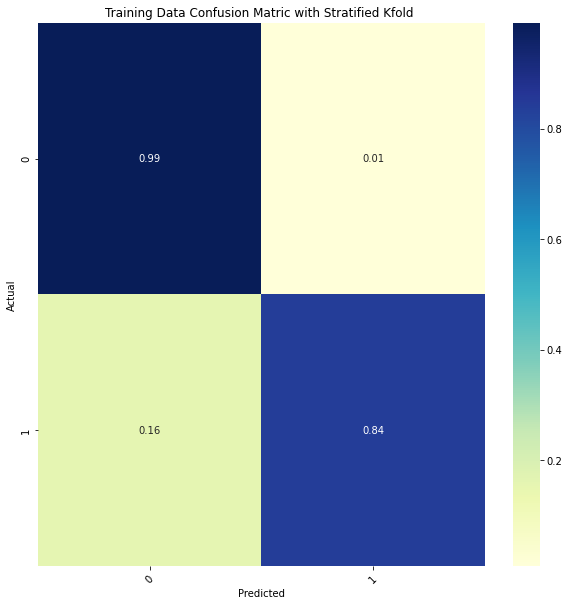


F1 Score: 0.9354633772537276
Precision: 0.9595380920371408
Recall: 0.9149041575627537
Accuracy: 0.9674760270041842


In [ ]:

conf_matrix = confusion_matrix(y_train, predictions)
print(conf_matrix, '\n')

conf_matrix_n = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_matrix_n, annot=True, fmt='.2f', cmap='YlGnBu',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Training Data Confusion Matric with Stratified Kfold ')
plt.xticks(rotation=45)
plt.show(block=False)

print('\nF1 Score: {}'.format(
    f1_score(y_train, predictions, average='macro')))
print('Precision: {}'.format(
    precision_score(y_train, predictions, average='weighted'))) #weighted to show AUC-Precision/Recall curve
print('Recall: {}'.format(
    recall_score(y_train, predictions, average='macro')))
print('Accuracy: {}'.format(
    accuracy_score(y_train, predictions, )))

**No Cross Validation below:**

In [20]:
model = neural_network
#Fit the model
model.fit(X_train_under, y_train_under, validation_data=(X_test, y_test), epochs=config.epochs, batch_size=config.batch_size, callbacks=[WandbCallback()])
test_pred = model.predict(X_test)
test_proba = model.predict_proba(X_test)
test_accuracy = roc_auc_score(y_test, test_proba[:,1])

print("Test AUC: {}".format(test_accuracy))

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/200
453/467 [============================>.] - ETA: 0s - loss: 1.5320 - accuracy: 0.5450 - f1_score: 0.5820 - auc: 0.5454

wandb: Adding directory to artifact (/content/wandb/run-20221219_070208-1sjn65rv/files/model-best)... Done. 0.0s


467/467 [==============================] - 6s 9ms/step - loss: 1.5069 - accuracy: 0.5453 - f1_score: 0.5835 - auc: 0.5468 - val_loss: 0.6948 - val_accuracy: 0.5059 - val_f1_score: 0.2951 - val_auc: 0.5928
Epoch 2/200
449/467 [===========================>..] - ETA: 0s - loss: 0.6840 - accuracy: 0.5670 - f1_score: 0.5819 - auc: 0.5887

wandb: Adding directory to artifact (/content/wandb/run-20221219_070208-1sjn65rv/files/model-best)... Done. 0.0s


467/467 [==============================] - 4s 8ms/step - loss: 0.6838 - accuracy: 0.5674 - f1_score: 0.5821 - auc: 0.5896 - val_loss: 0.6943 - val_accuracy: 0.5093 - val_f1_score: 0.3009 - val_auc: 0.6135
Epoch 3/200
453/467 [============================>.] - ETA: 0s - loss: 0.6792 - accuracy: 0.5797 - f1_score: 0.5956 - auc: 0.6140

wandb: Adding directory to artifact (/content/wandb/run-20221219_070208-1sjn65rv/files/model-best)... Done. 0.0s


467/467 [==============================] - 4s 8ms/step - loss: 0.6791 - accuracy: 0.5810 - f1_score: 0.5955 - auc: 0.6146 - val_loss: 0.6782 - val_accuracy: 0.5508 - val_f1_score: 0.3105 - val_auc: 0.6445
Epoch 4/200
467/467 [==============================] - 2s 5ms/step - loss: 0.6708 - accuracy: 0.5996 - f1_score: 0.6132 - auc: 0.6471 - val_loss: 0.7081 - val_accuracy: 0.4920 - val_f1_score: 0.3242 - val_auc: 0.6920
Epoch 5/200
459/467 [============================>.] - ETA: 0s - loss: 0.6597 - accuracy: 0.6184 - f1_score: 0.6303 - auc: 0.6810

wandb: Adding directory to artifact (/content/wandb/run-20221219_070208-1sjn65rv/files/model-best)... Done. 0.0s


467/467 [==============================] - 4s 8ms/step - loss: 0.6597 - accuracy: 0.6181 - f1_score: 0.6292 - auc: 0.6811 - val_loss: 0.6311 - val_accuracy: 0.6633 - val_f1_score: 0.3466 - val_auc: 0.7314
Epoch 6/200
466/467 [============================>.] - ETA: 0s - loss: 0.6441 - accuracy: 0.6479 - f1_score: 0.6565 - auc: 0.7234

wandb: Adding directory to artifact (/content/wandb/run-20221219_070208-1sjn65rv/files/model-best)... Done. 0.0s


467/467 [==============================] - 4s 8ms/step - loss: 0.6441 - accuracy: 0.6480 - f1_score: 0.6566 - auc: 0.7235 - val_loss: 0.6079 - val_accuracy: 0.7196 - val_f1_score: 0.4088 - val_auc: 0.7568
Epoch 7/200
456/467 [============================>.] - ETA: 0s - loss: 0.6210 - accuracy: 0.6782 - f1_score: 0.6883 - auc: 0.7617

wandb: Adding directory to artifact (/content/wandb/run-20221219_070208-1sjn65rv/files/model-best)... Done. 0.0s


467/467 [==============================] - 4s 9ms/step - loss: 0.6205 - accuracy: 0.6787 - f1_score: 0.6883 - auc: 0.7622 - val_loss: 0.6072 - val_accuracy: 0.7157 - val_f1_score: 0.4482 - val_auc: 0.7933
Epoch 8/200
462/467 [============================>.] - ETA: 0s - loss: 0.5854 - accuracy: 0.7168 - f1_score: 0.7234 - auc: 0.8006

wandb: Adding directory to artifact (/content/wandb/run-20221219_070208-1sjn65rv/files/model-best)... Done. 0.0s


467/467 [==============================] - 4s 9ms/step - loss: 0.5854 - accuracy: 0.7161 - f1_score: 0.7231 - auc: 0.8002 - val_loss: 0.6044 - val_accuracy: 0.6677 - val_f1_score: 0.4269 - val_auc: 0.8203
Epoch 9/200
460/467 [============================>.] - ETA: 0s - loss: 0.5518 - accuracy: 0.7412 - f1_score: 0.7485 - auc: 0.8220

wandb: Adding directory to artifact (/content/wandb/run-20221219_070208-1sjn65rv/files/model-best)... Done. 0.0s


467/467 [==============================] - 4s 8ms/step - loss: 0.5514 - accuracy: 0.7419 - f1_score: 0.7489 - auc: 0.8224 - val_loss: 0.4956 - val_accuracy: 0.8120 - val_f1_score: 0.5561 - val_auc: 0.8316
Epoch 10/200
460/467 [============================>.] - ETA: 0s - loss: 0.5148 - accuracy: 0.7847 - f1_score: 0.7874 - auc: 0.8409

wandb: Adding directory to artifact (/content/wandb/run-20221219_070208-1sjn65rv/files/model-best)... Done. 0.0s


467/467 [==============================] - 4s 8ms/step - loss: 0.5145 - accuracy: 0.7849 - f1_score: 0.7875 - auc: 0.8410 - val_loss: 0.4614 - val_accuracy: 0.8521 - val_f1_score: 0.6281 - val_auc: 0.8449
Epoch 11/200
451/467 [===========================>..] - ETA: 0s - loss: 0.4779 - accuracy: 0.8207 - f1_score: 0.8196 - auc: 0.8506

wandb: Adding directory to artifact (/content/wandb/run-20221219_070208-1sjn65rv/files/model-best)... Done. 0.0s


467/467 [==============================] - 4s 8ms/step - loss: 0.4778 - accuracy: 0.8208 - f1_score: 0.8193 - auc: 0.8499 - val_loss: 0.4521 - val_accuracy: 0.8543 - val_f1_score: 0.6396 - val_auc: 0.8487
Epoch 12/200
454/467 [============================>.] - ETA: 0s - loss: 0.4438 - accuracy: 0.8459 - f1_score: 0.8423 - auc: 0.8538

wandb: Adding directory to artifact (/content/wandb/run-20221219_070208-1sjn65rv/files/model-best)... Done. 0.0s


467/467 [==============================] - 4s 8ms/step - loss: 0.4435 - accuracy: 0.8465 - f1_score: 0.8426 - auc: 0.8541 - val_loss: 0.4460 - val_accuracy: 0.8335 - val_f1_score: 0.6105 - val_auc: 0.8497
Epoch 13/200
455/467 [============================>.] - ETA: 0s - loss: 0.4143 - accuracy: 0.8650 - f1_score: 0.8591 - auc: 0.8535

wandb: Adding directory to artifact (/content/wandb/run-20221219_070208-1sjn65rv/files/model-best)... Done. 0.0s


467/467 [==============================] - 4s 8ms/step - loss: 0.4136 - accuracy: 0.8654 - f1_score: 0.8596 - auc: 0.8539 - val_loss: 0.3740 - val_accuracy: 0.9069 - val_f1_score: 0.7367 - val_auc: 0.8492
Epoch 14/200
458/467 [============================>.] - ETA: 0s - loss: 0.3895 - accuracy: 0.8783 - f1_score: 0.8714 - auc: 0.8536

wandb: Adding directory to artifact (/content/wandb/run-20221219_070208-1sjn65rv/files/model-best)... Done. 0.0s


467/467 [==============================] - 4s 9ms/step - loss: 0.3889 - accuracy: 0.8784 - f1_score: 0.8717 - auc: 0.8541 - val_loss: 0.3324 - val_accuracy: 0.9246 - val_f1_score: 0.7755 - val_auc: 0.8507
Epoch 15/200
467/467 [==============================] - 3s 6ms/step - loss: 0.3677 - accuracy: 0.8886 - f1_score: 0.8813 - auc: 0.8544 - val_loss: 0.3429 - val_accuracy: 0.9312 - val_f1_score: 0.7910 - val_auc: 0.8467
Epoch 16/200
464/467 [============================>.] - ETA: 0s - loss: 0.3508 - accuracy: 0.8940 - f1_score: 0.8862 - auc: 0.8546

wandb: Adding directory to artifact (/content/wandb/run-20221219_070208-1sjn65rv/files/model-best)... Done. 0.0s


467/467 [==============================] - 4s 8ms/step - loss: 0.3502 - accuracy: 0.8943 - f1_score: 0.8866 - auc: 0.8551 - val_loss: 0.2852 - val_accuracy: 0.9442 - val_f1_score: 0.8234 - val_auc: 0.8490
Epoch 17/200
454/467 [============================>.] - ETA: 0s - loss: 0.3349 - accuracy: 0.8979 - f1_score: 0.8899 - auc: 0.8562

wandb: Adding directory to artifact (/content/wandb/run-20221219_070208-1sjn65rv/files/model-best)... Done. 0.0s


467/467 [==============================] - 4s 8ms/step - loss: 0.3349 - accuracy: 0.8979 - f1_score: 0.8900 - auc: 0.8561 - val_loss: 0.2793 - val_accuracy: 0.9611 - val_f1_score: 0.8697 - val_auc: 0.8471
Epoch 18/200
467/467 [==============================] - 3s 6ms/step - loss: 0.3209 - accuracy: 0.9026 - f1_score: 0.8946 - auc: 0.8561 - val_loss: 0.2867 - val_accuracy: 0.9554 - val_f1_score: 0.8537 - val_auc: 0.8469
Epoch 19/200
455/467 [============================>.] - ETA: 0s - loss: 0.3087 - accuracy: 0.9085 - f1_score: 0.9005 - auc: 0.8596

wandb: Adding directory to artifact (/content/wandb/run-20221219_070208-1sjn65rv/files/model-best)... Done. 0.0s


467/467 [==============================] - 5s 12ms/step - loss: 0.3089 - accuracy: 0.9083 - f1_score: 0.9002 - auc: 0.8592 - val_loss: 0.2410 - val_accuracy: 0.9681 - val_f1_score: 0.8907 - val_auc: 0.8498
Epoch 20/200
467/467 [==============================] - 3s 7ms/step - loss: 0.3006 - accuracy: 0.9104 - f1_score: 0.9022 - auc: 0.8569 - val_loss: 0.2446 - val_accuracy: 0.9677 - val_f1_score: 0.8896 - val_auc: 0.8496
Epoch 21/200
461/467 [============================>.] - ETA: 0s - loss: 0.2926 - accuracy: 0.9108 - f1_score: 0.9025 - auc: 0.8591

wandb: Adding directory to artifact (/content/wandb/run-20221219_070208-1sjn65rv/files/model-best)... Done. 0.0s


467/467 [==============================] - 4s 8ms/step - loss: 0.2924 - accuracy: 0.9109 - f1_score: 0.9027 - auc: 0.8592 - val_loss: 0.2227 - val_accuracy: 0.9683 - val_f1_score: 0.8915 - val_auc: 0.8533
Epoch 22/200
467/467 [==============================] - 2s 5ms/step - loss: 0.2866 - accuracy: 0.9105 - f1_score: 0.9023 - auc: 0.8647 - val_loss: 0.2282 - val_accuracy: 0.9668 - val_f1_score: 0.8869 - val_auc: 0.8566
Epoch 23/200
457/467 [============================>.] - ETA: 0s - loss: 0.2815 - accuracy: 0.9104 - f1_score: 0.9023 - auc: 0.8685

wandb: Adding directory to artifact (/content/wandb/run-20221219_070208-1sjn65rv/files/model-best)... Done. 0.0s


467/467 [==============================] - 4s 8ms/step - loss: 0.2810 - accuracy: 0.9107 - f1_score: 0.9025 - auc: 0.8687 - val_loss: 0.2150 - val_accuracy: 0.9687 - val_f1_score: 0.8926 - val_auc: 0.8670
Epoch 24/200
467/467 [==============================] - 3s 6ms/step - loss: 0.2767 - accuracy: 0.9109 - f1_score: 0.9027 - auc: 0.8797 - val_loss: 0.2452 - val_accuracy: 0.9649 - val_f1_score: 0.8814 - val_auc: 0.8804
Epoch 25/200
456/467 [============================>.] - ETA: 0s - loss: 0.2709 - accuracy: 0.9109 - f1_score: 0.9028 - auc: 0.8948

wandb: Adding directory to artifact (/content/wandb/run-20221219_070208-1sjn65rv/files/model-best)... Done. 0.0s


467/467 [==============================] - 4s 8ms/step - loss: 0.2710 - accuracy: 0.9109 - f1_score: 0.9027 - auc: 0.8948 - val_loss: 0.2100 - val_accuracy: 0.9682 - val_f1_score: 0.8912 - val_auc: 0.8964
Epoch 26/200
467/467 [==============================] - 2s 5ms/step - loss: 0.2650 - accuracy: 0.9108 - f1_score: 0.9026 - auc: 0.9084 - val_loss: 0.2250 - val_accuracy: 0.9681 - val_f1_score: 0.8909 - val_auc: 0.9145
Epoch 27/200
467/467 [==============================] - 3s 5ms/step - loss: 0.2582 - accuracy: 0.9112 - f1_score: 0.9030 - auc: 0.9223 - val_loss: 0.2281 - val_accuracy: 0.9678 - val_f1_score: 0.8898 - val_auc: 0.9276
Epoch 28/200
459/467 [============================>.] - ETA: 0s - loss: 0.2508 - accuracy: 0.9115 - f1_score: 0.9033 - auc: 0.9329

wandb: Adding directory to artifact (/content/wandb/run-20221219_070208-1sjn65rv/files/model-best)... Done. 0.0s


467/467 [==============================] - 4s 9ms/step - loss: 0.2515 - accuracy: 0.9111 - f1_score: 0.9029 - auc: 0.9327 - val_loss: 0.2088 - val_accuracy: 0.9689 - val_f1_score: 0.8933 - val_auc: 0.9374
Epoch 29/200
467/467 [==============================] - 3s 6ms/step - loss: 0.2433 - accuracy: 0.9109 - f1_score: 0.9027 - auc: 0.9420 - val_loss: 0.2123 - val_accuracy: 0.9685 - val_f1_score: 0.8921 - val_auc: 0.9452
Epoch 30/200
446/467 [===========================>..] - ETA: 0s - loss: 0.2357 - accuracy: 0.9110 - f1_score: 0.9029 - auc: 0.9490

wandb: Adding directory to artifact (/content/wandb/run-20221219_070208-1sjn65rv/files/model-best)... Done. 0.0s


467/467 [==============================] - 3s 7ms/step - loss: 0.2353 - accuracy: 0.9110 - f1_score: 0.9029 - auc: 0.9494 - val_loss: 0.1873 - val_accuracy: 0.9685 - val_f1_score: 0.8923 - val_auc: 0.9517
Epoch 31/200
459/467 [============================>.] - ETA: 0s - loss: 0.2284 - accuracy: 0.9125 - f1_score: 0.9046 - auc: 0.9546

wandb: Adding directory to artifact (/content/wandb/run-20221219_070208-1sjn65rv/files/model-best)... Done. 0.0s


467/467 [==============================] - 4s 8ms/step - loss: 0.2282 - accuracy: 0.9125 - f1_score: 0.9047 - auc: 0.9547 - val_loss: 0.1800 - val_accuracy: 0.9691 - val_f1_score: 0.8945 - val_auc: 0.9575
Epoch 32/200
461/467 [============================>.] - ETA: 0s - loss: 0.2195 - accuracy: 0.9150 - f1_score: 0.9078 - auc: 0.9606

wandb: Adding directory to artifact (/content/wandb/run-20221219_070208-1sjn65rv/files/model-best)... Done. 0.0s


467/467 [==============================] - 4s 8ms/step - loss: 0.2195 - accuracy: 0.9150 - f1_score: 0.9079 - auc: 0.9605 - val_loss: 0.1664 - val_accuracy: 0.9685 - val_f1_score: 0.8932 - val_auc: 0.9623
Epoch 33/200
467/467 [==============================] - 2s 5ms/step - loss: 0.2107 - accuracy: 0.9170 - f1_score: 0.9105 - auc: 0.9659 - val_loss: 0.1824 - val_accuracy: 0.9647 - val_f1_score: 0.8838 - val_auc: 0.9673
Epoch 34/200
467/467 [==============================] - 2s 5ms/step - loss: 0.2021 - accuracy: 0.9193 - f1_score: 0.9134 - auc: 0.9704 - val_loss: 0.1752 - val_accuracy: 0.9635 - val_f1_score: 0.8811 - val_auc: 0.9716
Epoch 35/200
467/467 [==============================] - 2s 5ms/step - loss: 0.1935 - accuracy: 0.9213 - f1_score: 0.9160 - auc: 0.9747 - val_loss: 0.1902 - val_accuracy: 0.9556 - val_f1_score: 0.8613 - val_auc: 0.9743
Epoch 36/200
460/467 [============================>.] - ETA: 0s - loss: 0.1851 - accuracy: 0.9232 - f1_score: 0.9184 - auc: 0.9780

wandb: Adding directory to artifact (/content/wandb/run-20221219_070208-1sjn65rv/files/model-best)... Done. 0.0s


467/467 [==============================] - 3s 7ms/step - loss: 0.1851 - accuracy: 0.9230 - f1_score: 0.9182 - auc: 0.9780 - val_loss: 0.1471 - val_accuracy: 0.9645 - val_f1_score: 0.8845 - val_auc: 0.9790
Epoch 37/200
467/467 [==============================] - 3s 6ms/step - loss: 0.1761 - accuracy: 0.9260 - f1_score: 0.9218 - auc: 0.9811 - val_loss: 0.1563 - val_accuracy: 0.9577 - val_f1_score: 0.8677 - val_auc: 0.9814
Epoch 38/200
467/467 [==============================] - 2s 5ms/step - loss: 0.1674 - accuracy: 0.9270 - f1_score: 0.9233 - auc: 0.9835 - val_loss: 0.1471 - val_accuracy: 0.9579 - val_f1_score: 0.8687 - val_auc: 0.9836
Epoch 39/200
453/467 [============================>.] - ETA: 0s - loss: 0.1590 - accuracy: 0.9292 - f1_score: 0.9260 - auc: 0.9857

wandb: Adding directory to artifact (/content/wandb/run-20221219_070208-1sjn65rv/files/model-best)... Done. 0.0s


467/467 [==============================] - 3s 7ms/step - loss: 0.1599 - accuracy: 0.9289 - f1_score: 0.9256 - auc: 0.9855 - val_loss: 0.1370 - val_accuracy: 0.9579 - val_f1_score: 0.8695 - val_auc: 0.9855
Epoch 40/200
461/467 [============================>.] - ETA: 0s - loss: 0.1541 - accuracy: 0.9314 - f1_score: 0.9287 - auc: 0.9868

wandb: Adding directory to artifact (/content/wandb/run-20221219_070208-1sjn65rv/files/model-best)... Done. 0.0s


467/467 [==============================] - 4s 8ms/step - loss: 0.1539 - accuracy: 0.9315 - f1_score: 0.9288 - auc: 0.9868 - val_loss: 0.1319 - val_accuracy: 0.9567 - val_f1_score: 0.8669 - val_auc: 0.9867
Epoch 41/200
467/467 [==============================] - 2s 5ms/step - loss: 0.1484 - accuracy: 0.9330 - f1_score: 0.9307 - auc: 0.9876 - val_loss: 0.1387 - val_accuracy: 0.9515 - val_f1_score: 0.8554 - val_auc: 0.9872
Epoch 42/200
456/467 [============================>.] - ETA: 0s - loss: 0.1432 - accuracy: 0.9347 - f1_score: 0.9326 - auc: 0.9886

wandb: Adding directory to artifact (/content/wandb/run-20221219_070208-1sjn65rv/files/model-best)... Done. 0.0s


467/467 [==============================] - 4s 8ms/step - loss: 0.1433 - accuracy: 0.9347 - f1_score: 0.9325 - auc: 0.9885 - val_loss: 0.1180 - val_accuracy: 0.9598 - val_f1_score: 0.8751 - val_auc: 0.9879
Epoch 43/200
467/467 [==============================] - 4s 9ms/step - loss: 0.1396 - accuracy: 0.9364 - f1_score: 0.9345 - auc: 0.9889 - val_loss: 0.1346 - val_accuracy: 0.9475 - val_f1_score: 0.8469 - val_auc: 0.9880
Epoch 44/200
461/467 [============================>.] - ETA: 0s - loss: 0.1362 - accuracy: 0.9366 - f1_score: 0.9349 - auc: 0.9892

wandb: Adding directory to artifact (/content/wandb/run-20221219_070208-1sjn65rv/files/model-best)... Done. 0.0s


467/467 [==============================] - 5s 10ms/step - loss: 0.1362 - accuracy: 0.9366 - f1_score: 0.9350 - auc: 0.9892 - val_loss: 0.1081 - val_accuracy: 0.9615 - val_f1_score: 0.8800 - val_auc: 0.9888
Epoch 45/200
467/467 [==============================] - 2s 5ms/step - loss: 0.1339 - accuracy: 0.9370 - f1_score: 0.9355 - auc: 0.9895 - val_loss: 0.1287 - val_accuracy: 0.9481 - val_f1_score: 0.8487 - val_auc: 0.9886
Epoch 46/200
467/467 [==============================] - 3s 6ms/step - loss: 0.1310 - accuracy: 0.9381 - f1_score: 0.9368 - auc: 0.9898 - val_loss: 0.1375 - val_accuracy: 0.9394 - val_f1_score: 0.8299 - val_auc: 0.9887
Epoch 47/200
467/467 [==============================] - 2s 5ms/step - loss: 0.1291 - accuracy: 0.9402 - f1_score: 0.9391 - auc: 0.9898 - val_loss: 0.1367 - val_accuracy: 0.9396 - val_f1_score: 0.8306 - val_auc: 0.9890
Epoch 48/200
467/467 [==============================] - 2s 5ms/step - loss: 0.1273 - accuracy: 0.9394 - f1_score: 0.9384 - auc: 0.9899 - val

wandb: Adding directory to artifact (/content/wandb/run-20221219_070208-1sjn65rv/files/model-best)... Done. 0.0s


467/467 [==============================] - 4s 8ms/step - loss: 0.1173 - accuracy: 0.9444 - f1_score: 0.9439 - auc: 0.9910 - val_loss: 0.0964 - val_accuracy: 0.9599 - val_f1_score: 0.8780 - val_auc: 0.9906
Epoch 57/200
467/467 [==============================] - 2s 5ms/step - loss: 0.1175 - accuracy: 0.9445 - f1_score: 0.9440 - auc: 0.9908 - val_loss: 0.1026 - val_accuracy: 0.9566 - val_f1_score: 0.8702 - val_auc: 0.9906
Epoch 58/200
455/467 [============================>.] - ETA: 0s - loss: 0.1166 - accuracy: 0.9445 - f1_score: 0.9441 - auc: 0.9911

wandb: Adding directory to artifact (/content/wandb/run-20221219_070208-1sjn65rv/files/model-best)... Done. 0.0s


467/467 [==============================] - 4s 8ms/step - loss: 0.1162 - accuracy: 0.9448 - f1_score: 0.9444 - auc: 0.9911 - val_loss: 0.0875 - val_accuracy: 0.9674 - val_f1_score: 0.8967 - val_auc: 0.9908
Epoch 59/200
467/467 [==============================] - 3s 6ms/step - loss: 0.1165 - accuracy: 0.9435 - f1_score: 0.9430 - auc: 0.9911 - val_loss: 0.1038 - val_accuracy: 0.9543 - val_f1_score: 0.8652 - val_auc: 0.9908
Epoch 60/200
467/467 [==============================] - 2s 5ms/step - loss: 0.1157 - accuracy: 0.9453 - f1_score: 0.9449 - auc: 0.9911 - val_loss: 0.1013 - val_accuracy: 0.9574 - val_f1_score: 0.8727 - val_auc: 0.9907
Epoch 61/200
467/467 [==============================] - 2s 5ms/step - loss: 0.1147 - accuracy: 0.9454 - f1_score: 0.9450 - auc: 0.9913 - val_loss: 0.1231 - val_accuracy: 0.9384 - val_f1_score: 0.8303 - val_auc: 0.9907
Epoch 62/200
467/467 [==============================] - 2s 5ms/step - loss: 0.1138 - accuracy: 0.9460 - f1_score: 0.9456 - auc: 0.9913 - val_

wandb: Adding directory to artifact (/content/wandb/run-20221219_070208-1sjn65rv/files/model-best)... Done. 0.0s


467/467 [==============================] - 4s 8ms/step - loss: 0.1056 - accuracy: 0.9519 - f1_score: 0.9522 - auc: 0.9922 - val_loss: 0.0867 - val_accuracy: 0.9597 - val_f1_score: 0.8799 - val_auc: 0.9917
Epoch 100/200
467/467 [==============================] - 3s 6ms/step - loss: 0.1060 - accuracy: 0.9523 - f1_score: 0.9525 - auc: 0.9922 - val_loss: 0.1013 - val_accuracy: 0.9521 - val_f1_score: 0.8628 - val_auc: 0.9920
Epoch 101/200
467/467 [==============================] - 3s 5ms/step - loss: 0.1062 - accuracy: 0.9517 - f1_score: 0.9519 - auc: 0.9921 - val_loss: 0.0973 - val_accuracy: 0.9538 - val_f1_score: 0.8667 - val_auc: 0.9918
Epoch 102/200
467/467 [==============================] - 3s 5ms/step - loss: 0.1052 - accuracy: 0.9525 - f1_score: 0.9527 - auc: 0.9923 - val_loss: 0.0998 - val_accuracy: 0.9527 - val_f1_score: 0.8643 - val_auc: 0.9920
Epoch 103/200
467/467 [==============================] - 3s 6ms/step - loss: 0.1051 - accuracy: 0.9531 - f1_score: 0.9533 - auc: 0.9924 - 

wandb: Adding directory to artifact (/content/wandb/run-20221219_070208-1sjn65rv/files/model-best)... Done. 0.0s


467/467 [==============================] - 4s 8ms/step - loss: 0.1047 - accuracy: 0.9524 - f1_score: 0.9526 - auc: 0.9924 - val_loss: 0.0858 - val_accuracy: 0.9669 - val_f1_score: 0.8977 - val_auc: 0.9916
Epoch 107/200
467/467 [==============================] - 3s 6ms/step - loss: 0.1050 - accuracy: 0.9529 - f1_score: 0.9532 - auc: 0.9923 - val_loss: 0.1039 - val_accuracy: 0.9508 - val_f1_score: 0.8598 - val_auc: 0.9919
Epoch 108/200
467/467 [==============================] - 2s 5ms/step - loss: 0.1057 - accuracy: 0.9525 - f1_score: 0.9528 - auc: 0.9922 - val_loss: 0.1301 - val_accuracy: 0.9325 - val_f1_score: 0.8198 - val_auc: 0.9920
Epoch 109/200
467/467 [==============================] - 2s 5ms/step - loss: 0.1049 - accuracy: 0.9518 - f1_score: 0.9520 - auc: 0.9922 - val_loss: 0.1057 - val_accuracy: 0.9494 - val_f1_score: 0.8566 - val_auc: 0.9922
Epoch 110/200
467/467 [==============================] - 3s 5ms/step - loss: 0.1043 - accuracy: 0.9532 - f1_score: 0.9535 - auc: 0.9922 - 

wandb: Adding directory to artifact (/content/wandb/run-20221219_070208-1sjn65rv/files/model-best)... Done. 0.0s


467/467 [==============================] - 4s 8ms/step - loss: 0.1046 - accuracy: 0.9534 - f1_score: 0.9536 - auc: 0.9923 - val_loss: 0.0821 - val_accuracy: 0.9672 - val_f1_score: 0.8981 - val_auc: 0.9913
Epoch 116/200
467/467 [==============================] - 3s 6ms/step - loss: 0.1047 - accuracy: 0.9525 - f1_score: 0.9527 - auc: 0.9923 - val_loss: 0.1330 - val_accuracy: 0.9306 - val_f1_score: 0.8161 - val_auc: 0.9922
Epoch 117/200
467/467 [==============================] - 2s 5ms/step - loss: 0.1049 - accuracy: 0.9536 - f1_score: 0.9538 - auc: 0.9922 - val_loss: 0.1248 - val_accuracy: 0.9366 - val_f1_score: 0.8288 - val_auc: 0.9921
Epoch 118/200
467/467 [==============================] - 4s 9ms/step - loss: 0.1047 - accuracy: 0.9526 - f1_score: 0.9528 - auc: 0.9922 - val_loss: 0.0985 - val_accuracy: 0.9534 - val_f1_score: 0.8657 - val_auc: 0.9919
Epoch 119/200
467/467 [==============================] - 3s 6ms/step - loss: 0.1052 - accuracy: 0.9525 - f1_score: 0.9527 - auc: 0.9921 - 

-----------
Train predictions & confusion matrix

In [21]:
prediction_train = (model.predict(X_train) > 0.5).astype("int32")

1498/1498 [==============================] - 3s 2ms/step


[[74565  6336]
 [  313 14623]] 



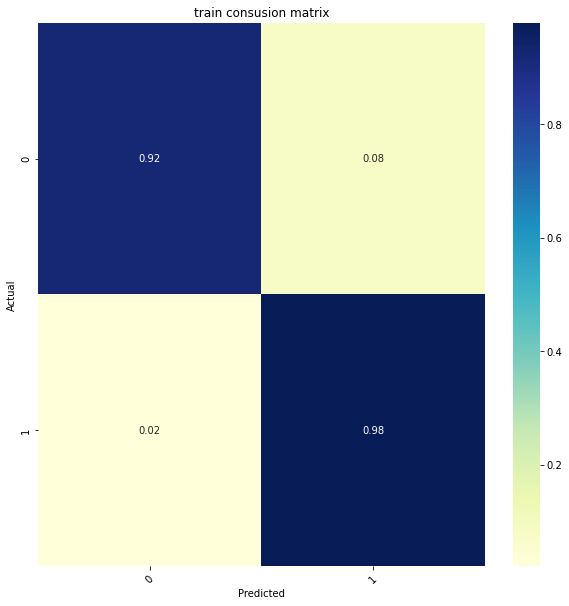


F1 Score: 0.886041513117864
Precision: 0.9493577956101311
Recall: 0.9503629882872378
Accuracy: 0.930621784905621


In [22]:
##train confusion matrix

conf_matrix = confusion_matrix(y_train, prediction_train)
print(conf_matrix, '\n')

conf_matrix_n = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_matrix_n, annot=True, fmt='.2f', cmap='YlGnBu',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('train consusion matrix')
plt.xticks(rotation=45)
plt.show(block=False)

print('\nF1 Score: {}'.format(
    f1_score(y_train, prediction_train, average='macro')))
print('Precision: {}'.format(
    precision_score(y_train, prediction_train, average='weighted'))) #weighted to show AUC-Precision/Recall curve
print('Recall: {}'.format(
    recall_score(y_train, prediction_train, average='macro')))
print('Accuracy: {}'.format(
    accuracy_score(y_train, prediction_train, )))

-----------
Undersanpled train predictions & confusion matrix

In [23]:
#undersampling predictions
prediction_train_under = (model.predict(X_train_under) > 0.5).astype("int32")

467/467 [==============================] - 1s 2ms/step


[[13799  1137]
 [  313 14623]] 



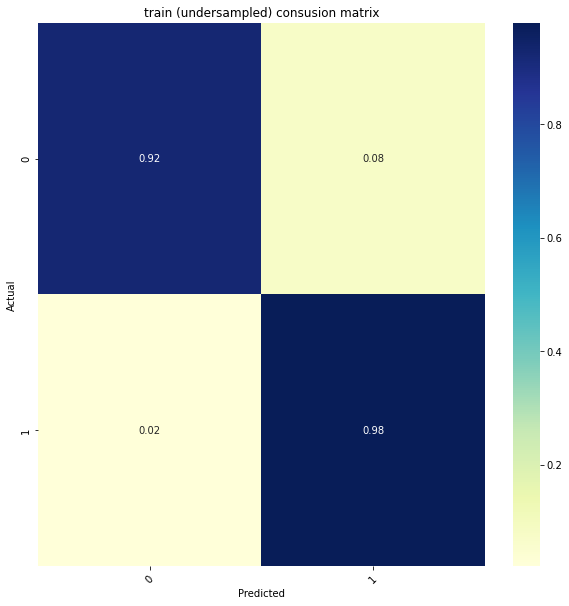


F1 Score: 0.9514225983977918
Precision: 0.9528378123669096
Recall: 0.9514595607927157
Accuracy: 0.9514595607927155


In [24]:
##train under confusion matrix

conf_matrix = confusion_matrix(y_train_under, prediction_train_under)
print(conf_matrix, '\n')

conf_matrix_n = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_matrix_n, annot=True, fmt='.2f', cmap='YlGnBu',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('train (undersampled) consusion matrix')
plt.xticks(rotation=45)
plt.show(block=False)

print('\nF1 Score: {}'.format(
    f1_score(y_train_under, prediction_train_under, average='macro')))
print('Precision: {}'.format(
    precision_score(y_train_under, prediction_train_under, average='weighted'))) #weighted to show AUC-Precision/Recall curve
print('Recall: {}'.format(
    recall_score(y_train_under, prediction_train_under, average='macro')))
print('Accuracy: {}'.format(
    accuracy_score(y_train_under, prediction_train_under, )))

-----------
Test predictions & confusion matrix

In [25]:
prediction_test = (model.predict(X_test) > 0.5).astype("int32")

642/642 [==============================] - 1s 2ms/step


/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/200
1498/1498 [==============================] - 9s 4ms/step - loss: 0.4375 - accuracy: 0.8430 - f1_score: 0.0011 - auc_1: 0.5739
Epoch 2/200
1498/1498 [==============================] - 6s 4ms/step - loss: 0.3704 - accuracy: 0.8499 - f1_score: 0.0829 - auc_1: 0.7734
Epoch 3/200
1498/1498 [==============================] - 6s 4ms/step - loss: 0.2974 - accuracy: 0.9037 - f1_score: 0.5610 - auc_1: 0.8593
Epoch 4/200
1498/1498 [==============================] - 6s 4ms/step - loss: 0.2399 - accuracy: 0.9532 - f1_score: 0.8268 - auc_1: 0.8706
Epoch 5/200
1498/1498 [==============================] - 7s 4ms/step - loss: 0.2117 - accuracy: 0.9642 - f1_score: 0.8732 - auc_1: 0.8764
Epoch 6/200
1498/1498 [==============================] - 7s 4ms/step - loss: 0.1992 - accuracy: 0.9642 - f1_score: 0.8742 - auc_1: 0.8844
Epoch 7/200
1498/1498 [==============================] - 7s 4ms/step - loss: 0.1934 - accuracy: 0.9637 - f1_score: 0.8729 - auc_1: 0.8902
Epoch 8/200
1498/1498 [===========

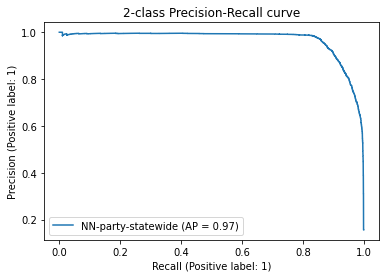

In [ ]:
#PR-curve
neural_network.fit(X_train, y_train)


from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    neural_network, X_test, y_test, name="NN-party-statewide"
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

[[31822  2749]
 [  150  6353]] 



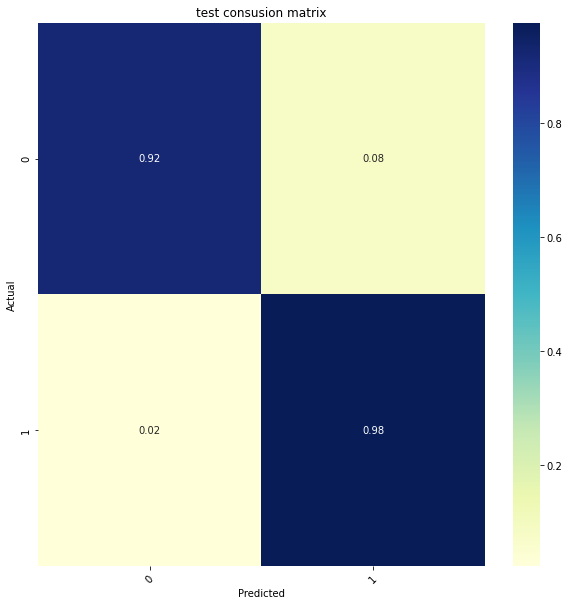


F1 Score: 0.8853301974810823
Precision: 0.9482339310601527
Recall: 0.9487081041085952
Accuracy: 0.9294200710912013


In [26]:
#test confusion matrix
conf_matrix = confusion_matrix(y_test, prediction_test)
print(conf_matrix, '\n')

conf_matrix_n = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_matrix_n, annot=True, fmt='.2f', cmap='YlGnBu',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('test consusion matrix')
plt.xticks(rotation=45)
plt.show(block=False)

print('\nF1 Score: {}'.format(
    f1_score(y_test, prediction_test, average='macro')))
print('Precision: {}'.format(
    precision_score(y_test, prediction_test, average='weighted'))) #weighted to show AUC-Precision/Recall curve
print('Recall: {}'.format(
    recall_score(y_test, prediction_test, average='macro')))
print('Accuracy: {}'.format(
    accuracy_score(y_test, prediction_test, )))

-----------
Undersanpled test predictions & confusion matrix

In [27]:
#undersampling (test_under) predictions
prediction_test_under = (model.predict(X_test_under) > 0.5).astype("int32")

204/204 [==============================] - 0s 2ms/step


[[5976  527]
 [ 150 6353]] 



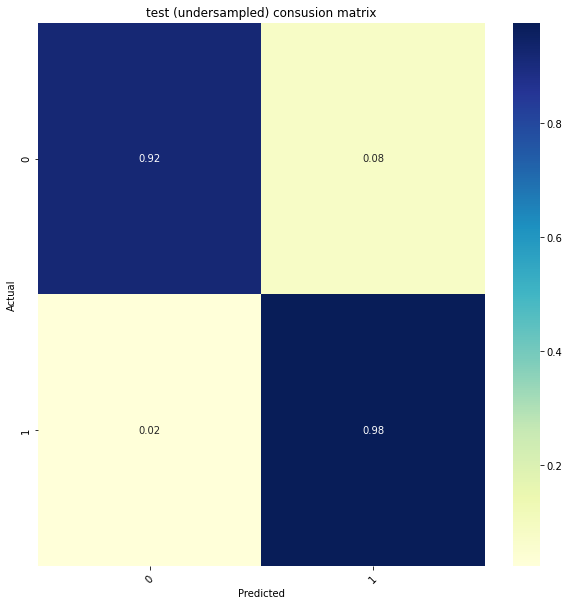


F1 Score: 0.9479033284521373
Precision: 0.9494576822768376
Recall: 0.9479471013378441
Accuracy: 0.9479471013378441


In [28]:
#test_under confusion matrix
conf_matrix = confusion_matrix(y_test_under, prediction_test_under)
print(conf_matrix, '\n')

conf_matrix_n = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_matrix_n, annot=True, fmt='.2f', cmap='YlGnBu',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('test (undersampled) consusion matrix')
plt.xticks(rotation=45)
plt.show(block=False)

print('\nF1 Score: {}'.format(
    f1_score(y_test_under, prediction_test_under, average='macro')))
print('Precision: {}'.format(
    precision_score(y_test_under, prediction_test_under, average='weighted'))) #weighted to show AUC-Precision/Recall curve
print('Recall: {}'.format(
    recall_score(y_test_under, prediction_test_under, average='macro')))
print('Accuracy: {}'.format(
    accuracy_score(y_test_under, prediction_test_under, )))